# Total COVID-19 deaths for different US states

Script produced by [Laurent Lessard](https://laurentlessard.com)

---

### Import data from covidtracking.com

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import datetime

mpl.rcParams['figure.dpi'] = 120

url = "https://covidtracking.com/api/states/daily.csv"
df_raw = pd.read_csv(url)

C:\Users\laure\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Reformat data into convenient form

In [2]:
# aggregate by state
df = df_raw.pivot_table(index='date',values='death',columns='state')

# make the index a datetime object
df = df.set_index( pd.to_datetime(df.index, format="%Y%m%d") )

# sort the dates/times
df.sort_index(inplace=True)

# record the latest date
latest_date = df.index[-1]
latest_date_str = latest_date.strftime("%a %b %d, %Y")
print(latest_date_str)

Thu Jan 07, 2021


### List of states with the most total deaths

In [3]:
deaths_sorted = df.iloc[-1].sort_values(ascending=False)
deaths_sorted.head(20)

state
NY    31164.0
TX    28938.0
CA    28045.0
FL    22817.0
NJ    19646.0
IL    18941.0
PA    17179.0
MI    13873.0
MA    12909.0
GA    11230.0
AZ     9741.0
OH     9462.0
IN     8823.0
LA     7728.0
TN     7492.0
NC     7213.0
CT     6287.0
MD     6173.0
MO     5882.0
SC     5661.0
Name: 2021-01-07 00:00:00, dtype: float64

### List of states with the most daily deaths

In [4]:
daily_deaths_sorted = df.diff().iloc[-1].sort_values(ascending=False)
daily_deaths_sorted.head(15)

state
CA    583.0
TX    393.0
AZ    297.0
PA    265.0
IL    206.0
MI    206.0
NY    199.0
FL    170.0
NC    137.0
NJ    123.0
TN    111.0
OH     94.0
AL     86.0
IN     80.0
SC     79.0
Name: 2021-01-07 00:00:00, dtype: float64

### List of states with at least 100 deaths

In [5]:
states = df.columns[df.iloc[-1] >= 100]

for (i,c) in enumerate(states):
    print( c.ljust(4), end=' ')
    if (i+1) % 12 == 0:
        print()

AK   AL   AR   AZ   CA   CO   CT   DC   DE   FL   GA   GU   
HI   IA   ID   IL   IN   KS   KY   LA   MA   MD   ME   MI   
MN   MO   MS   MT   NC   ND   NE   NH   NJ   NM   NV   NY   
OH   OK   OR   PA   PR   RI   SC   SD   TN   TX   UT   VA   
VT   WA   WI   WV   WY   

### Plot shifted death toll for selected states

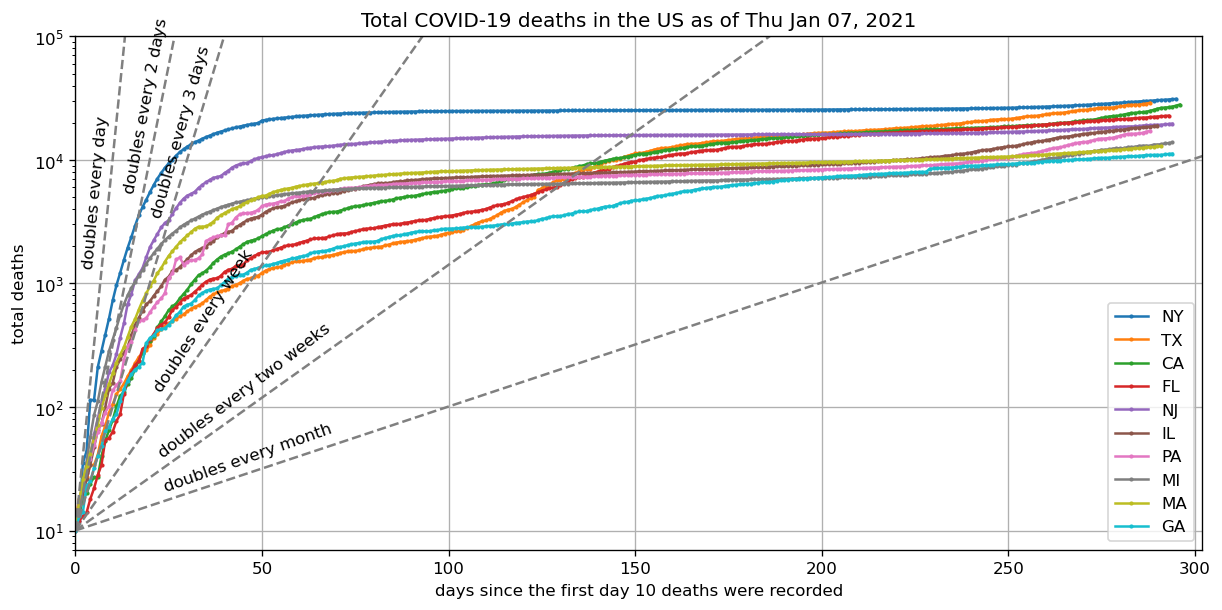

In [6]:
# function that shifts the data so everything starts from first min_deaths
def shift_data( states, min_deaths ):
    shifted_data = []
    for (c,data) in df[states].items():
        shifted_data.append( data[data >= min_deaths].reset_index(drop=True) )
    return shifted_data

# selected states
states = deaths_sorted[:10].index
# states = ['NY','NJ','MI','MA','IL','CA','CT','FL','WA','WI']
min_deaths = 10

# shift data so that index corresponds to days since min_death deaths.
shifted_data = shift_data( states, min_deaths )
data_len = max([len(dat) for dat in shifted_data])

xmax = data_len + 5

# merge into a single dataframe
dfx = pd.concat( shifted_data, axis=1 )

# make plot
ax = dfx.plot(title="Total COVID-19 deaths in the US as of %s" % latest_date_str, logy=True, figsize=(10,5), grid=True, marker='.', markersize=3);
ax.set_xlabel("days since the first day %g deaths were recorded" % min_deaths )
ax.set_ylabel("total deaths")
ax.set_ylim(min_deaths*.7,1e5)
ax.set_xlim(0,xmax);

# draw doubling lines (doubling every d days)
dvals = [1,2,3,7,14,30]    # values of doubling lines to draw (d)
dtxt = ["day", "2 days", "3 days", "week", "two weeks", "month"]
tloc = [7,18,25,25,25,25] # x-coordinate of text labels
for i,d in enumerate(dvals):
    tx = tloc[i]
    ty = min_deaths*(2**(tx/d))
    angle = np.arctan(ty/d * np.log(2))
    angle_screen = ax.transData.transform_angles(np.array([angle,]),np.array([[tx,ty]]),radians=True)[0]
    y = min_deaths*(2**(xmax/d))
    plt.plot([0,xmax],[min_deaths,y], '--', color='gray')
    ax.annotate("doubles every %s" % dtxt[i], xy=(tx,ty), xytext=(-5*np.sin(angle_screen),5*np.cos(angle_screen)),
                textcoords="offset points", rotation_mode='anchor', rotation=np.rad2deg(angle_screen))
plt.tight_layout(pad=0)
plt.savefig("figures/states_total_deaths_vs_time.png")

### Plot daily deaths

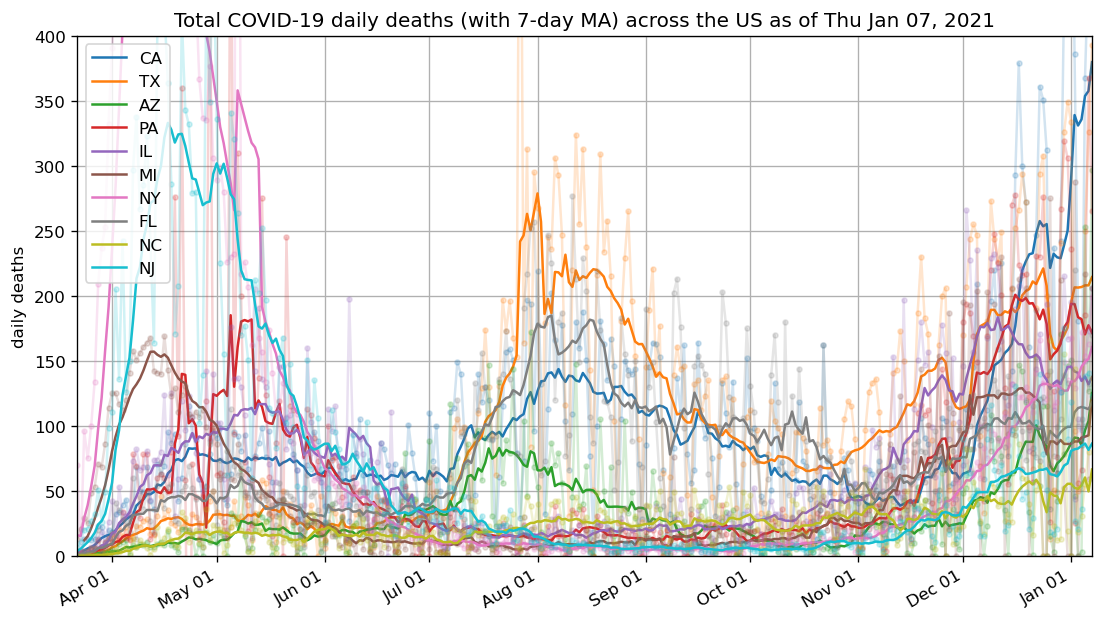

In [9]:
fig = plt.figure(figsize=(9,5))
ax = plt.gca()

# selected countries
states = daily_deaths_sorted[:10].index

for s in states:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot( df[s].diff(), marker=".", label=None, color=color, alpha=0.2 )
    plt.plot( df[s].diff().rolling(7).mean(), marker="", label=s, color=color, linewidth=1.5 )

# make plot
ax.set_title("Total COVID-19 daily deaths (with 7-day MA) across the US as of %s" % latest_date_str)
ax.legend(loc="upper left")
ax.set_ylabel("daily deaths")
ax.grid()
ax.set_xlim(xmin = datetime.date(2020, 3, 22), xmax = latest_date )
ax.set_ylim(ymin=0,ymax=400)

fig.autofmt_xdate()
date_format = "%b %d"
# ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter(date_format))
    
plt.tight_layout(pad=0)
plt.savefig("figures/states_daily_deaths_vs_time.png")

# Consider daily cases

In [10]:
# get state populations (2018 census)
url = "https://raw.githubusercontent.com/COVID19Tracking/associated-data/master/us_census_data/us_census_2018_population_estimates_states.csv"
df_pop = pd.read_csv(url, index_col="state", usecols=["state","state_name","population"])
df_pop.loc["DC","state_name"] = "Washington D.C."

# aggregate by state
dfc = df_raw.pivot_table(index='date',values='positive',columns='state')

# make the index a datetime object
dfc = dfc.set_index( pd.to_datetime(dfc.index, format="%Y%m%d") )

# sort the dates/times
dfc.sort_index(inplace=True)

# only keep states we have population data for
states = list(df_pop.index)
dfc = dfc[states]

# record the latest date
latest_date = dfc.index[-1]
latest_date_str = latest_date.strftime("%a %b %d, %Y")
print(latest_date_str)

# order states by most recent case rate
data_normalized = dfc.diff().rolling(7).mean().iloc[-1] / df_pop.population
state_order = data_normalized.sort_values().index

Thu Jan 07, 2021


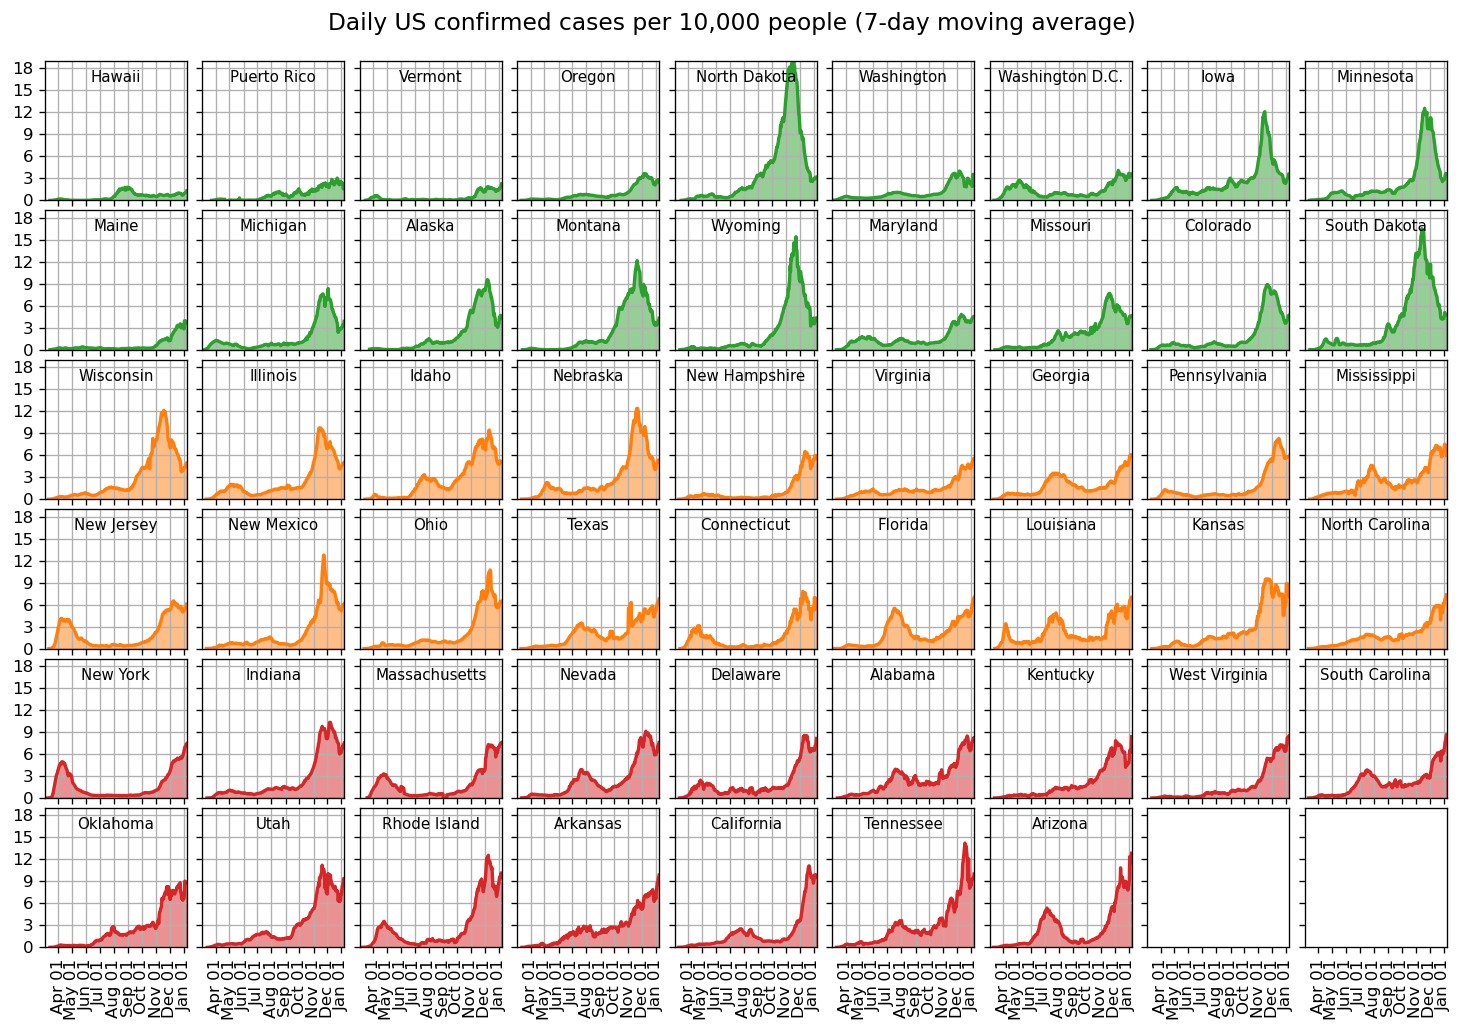

In [11]:
fig,axs = plt.subplots(6,9, figsize=(12,8), sharey=True, sharex=True)

# curves that go up and down (13)
cat1 = state_order[:18]

# curves that flattened but now are growing again (3)
cat2 = state_order[18:36]

# curves that just go straight up (5)
cat3 = state_order[36:]

pop_scale = 10000

for ix,state in enumerate(state_order):
    if ix < 18:
        col = "C2"
    elif ix < 36:
        col = "C1"
    else:
        col = "C3"
    
    ax = axs.reshape(-1)[ix]
    data = dfc[state]
    population = df_pop.population[state]
    state_name = df_pop.state_name[state]
    ax.fill_between( x=data.index, y1=data.diff().rolling(7).mean() / population * pop_scale, alpha=0.5, color=col )
    ax.plot( data.diff().rolling(7).mean() / population * pop_scale, linewidth=2, color=col )
    txt = ax.text(.5,.85, state_name,
            horizontalalignment='center',
            transform=ax.transAxes,
            fontsize=9)
    ax.grid()
    date_format = "%b %d"
    ax.xaxis.set_major_formatter(DateFormatter(date_format))
    ax.autoscale(enable=True, axis='x', tight=True)
    date_start = datetime.date(2020, 3, 3)
#     date_end   = datetime.date(2020, 7, 1)
    ax.set_xlim(xmin=date_start)
    
    months = mdates.MonthLocator()  # every month
    ax.xaxis.set_major_locator(months)
    
    ax.set_ylim(ymin=0,ymax=19)
    ax.set_yticks(range(0,19,3))

fig.autofmt_xdate(rotation=90, ha='center')
my_suptitle = fig.suptitle("Daily US confirmed cases per 10,000 people (7-day moving average)", fontsize=14, y=1.05)

plt.tight_layout(pad=0)
plt.savefig("figures/states_daily_cases_breakdown.png", dpi=fig.dpi, bbox_inches='tight', bbox_extra_artists=[my_suptitle])

## Heatmap of new cases by state

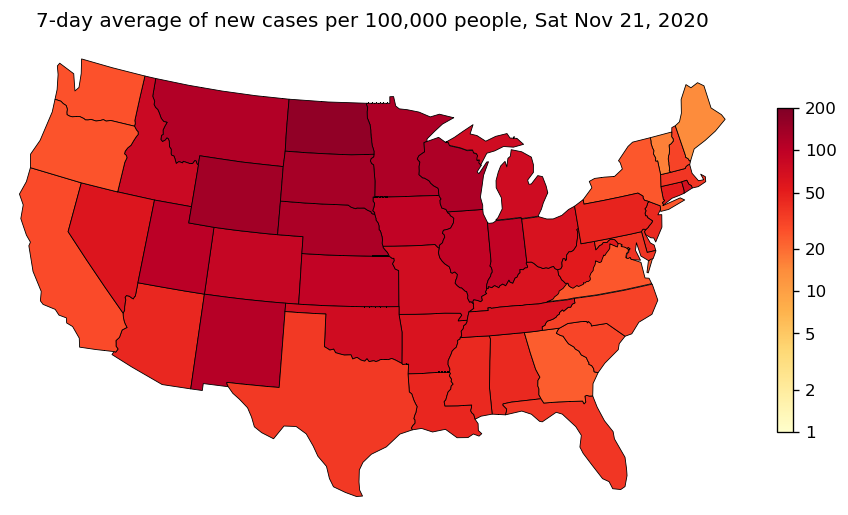

In [15]:
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors

LOG_SCALE = True

# get the normalized data and pick a colormap
data_normalized = ( dfc.diff().rolling(7).mean().iloc[-1] / df_pop.population * 100000 ).sort_values()
cmap = mpl.cm.get_cmap('YlOrRd')
cases_max = 200

fig = plt.figure(figsize=(7.5,4.5))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(), frameon=False)
ax.patch.set_visible(False)
ax.set_extent([-119, -74, 23, 51], ccrs.Geodetic())

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

for rec in shpreader.Reader(states_shp).records():

#     facecolor = (0.9375, 0.9375, 0.859375)
    edgecolor = 'black'
    linewidth = 0.5
    
    state = rec.attributes['postal']
    new_cases = data_normalized[state]
    
    if LOG_SCALE:
        facecolor = cmap( np.log10(new_cases) / np.log10(cases_max) )
    else:
        facecolor = cmap( new_cases / cases_max )
        
    ax.add_geometries([rec.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, linewidth=linewidth)

if LOG_SCALE:    
    ticks = [1,2,5,10,20,50,100,200]
    cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin=1, vmax=cases_max, clip=False), cmap=cmap), ax=ax, shrink=0.6, ticks=ticks)
    cbar.ax.set_yticklabels(ticks)
    cbar.ax.minorticks_off()
else:
    fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=cases_max, clip=False), cmap=cmap), ax=ax, shrink=0.6)    

ax.set_title('7-day average of new cases per 100,000 people, %s' % latest_date_str)

plt.savefig("figures/states_daily_cases_map.png")

In [17]:
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.animation as animation

LOG_SCALE = True

def plot_data(date_str, data_normalized):
    
    cmap = mpl.cm.get_cmap('YlOrRd')
    cases_max = 200
    
    fig = plt.figure(figsize=(7.5,4.5))
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(), frameon=False)
    ax.patch.set_visible(False)
    ax.set_extent([-119, -74, 23, 51], ccrs.Geodetic())

    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    for rec in shpreader.Reader(states_shp).records():

        edgecolor = 'black'
        linewidth = 0.5

        state = rec.attributes['postal']
        new_cases = data_normalized[state]

        if LOG_SCALE:
            facecolor = cmap( np.log10(new_cases) / np.log10(cases_max) )
        else:
            facecolor = cmap( new_cases / cases_max )

        ax.add_geometries([rec.geometry], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor, linewidth=linewidth)

    if LOG_SCALE:    
        ticks = [1,2,5,10,20,50,100,200]
        cbar = fig.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin=1, vmax=cases_max, clip=False), cmap=cmap), ax=ax, shrink=0.6, ticks=ticks)
        cbar.ax.set_yticklabels(ticks)
        cbar.ax.minorticks_off()
    else:
        fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=cases_max, clip=False), cmap=cmap), ax=ax, shrink=0.6)    

    ax.set_title('7-day average of new cases per 100,000 people, %s' % date_str)
    
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.clf()
    plt.close()

    return image

In [20]:
import imageio

mpl.rcParams['figure.dpi'] = 300  # default is 120

tinit = 39  # start on March 1
tfinal = len(dfc) # go to today

# tinit = 98
# tfinal = 125

# for t in range(tinit,tfinal):
#     print(f"{t} of {tfinal-1}")
#     date_str = dfc.index[t].strftime("%b %d, %Y")
#     data_normalized = (dfc.diff().rolling(7).mean().iloc[t] / df_pop.population * 100000).sort_values()
#     imageio.imsave( f'animation/img_{t:03}.png', plot_data(date_str, data_normalized) )

# kwargs_write = {'fps':1.0, 'quantizer':'nq'}
# imageio.mimsave('figures/states_daily_cases_map_animation.gif', imgs, fps=4)

39 of 304


<ipython-input-17-7ad4af2f0906>:33: RuntimeWarning: divide by zero encountered in log10
  facecolor = cmap( np.log10(new_cases) / np.log10(cases_max) )


40 of 304
41 of 304
42 of 304
43 of 304
44 of 304
45 of 304
46 of 304
47 of 304
48 of 304
49 of 304
50 of 304
51 of 304
52 of 304
53 of 304
54 of 304
55 of 304
56 of 304
57 of 304
58 of 304
59 of 304
60 of 304
61 of 304
62 of 304
63 of 304
64 of 304
65 of 304
66 of 304
67 of 304
68 of 304
69 of 304
70 of 304
71 of 304
72 of 304
73 of 304
74 of 304
75 of 304
76 of 304
77 of 304
78 of 304
79 of 304
80 of 304
81 of 304
82 of 304
83 of 304
84 of 304
85 of 304
86 of 304
87 of 304
88 of 304
89 of 304
90 of 304
91 of 304
92 of 304
93 of 304
94 of 304
95 of 304
96 of 304
97 of 304
98 of 304
99 of 304
100 of 304
101 of 304
102 of 304
103 of 304
104 of 304
105 of 304
106 of 304
107 of 304
108 of 304
109 of 304
110 of 304
111 of 304
112 of 304
113 of 304
114 of 304
115 of 304
116 of 304
117 of 304
118 of 304
119 of 304
120 of 304
121 of 304
122 of 304
123 of 304
124 of 304
125 of 304
126 of 304
127 of 304
128 of 304
129 of 304
130 of 304
131 of 304
132 of 304
133 of 304
134 of 304
135 of 304
136 

<ipython-input-17-7ad4af2f0906>:33: RuntimeWarning: invalid value encountered in log10
  facecolor = cmap( np.log10(new_cases) / np.log10(cases_max) )


225 of 304
226 of 304
227 of 304
228 of 304
229 of 304
230 of 304
231 of 304
232 of 304
233 of 304
234 of 304
235 of 304
236 of 304
237 of 304
238 of 304
239 of 304
240 of 304
241 of 304
242 of 304
243 of 304
244 of 304
245 of 304
246 of 304
247 of 304
248 of 304
249 of 304
250 of 304
251 of 304
252 of 304
253 of 304
254 of 304
255 of 304
256 of 304
257 of 304
258 of 304
259 of 304
260 of 304
261 of 304
262 of 304
263 of 304
264 of 304
265 of 304
266 of 304
267 of 304
268 of 304
269 of 304
270 of 304
271 of 304
272 of 304
273 of 304
274 of 304
275 of 304
276 of 304
277 of 304
278 of 304
279 of 304
280 of 304
281 of 304
282 of 304
283 of 304
284 of 304
285 of 304
286 of 304
287 of 304
288 of 304
289 of 304
290 of 304
291 of 304
292 of 304
293 of 304
294 of 304
295 of 304
296 of 304
297 of 304
298 of 304
299 of 304
300 of 304
301 of 304
302 of 304
303 of 304
304 of 304
